# GroMore base model domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in C:\Users\vivek\Anaconda3\lib\site-packages\flopy


# The following outlines our 10 ensembles 

## The high drawdown set

### Ensemble 1
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 2
KU and KL, HKM: 
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 3
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 4
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [5e-5] - high
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 5
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1] - high


## The low drawdown set

### Ensemble 6
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1e-2] - low
### Ensemble 7
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [1e-5] - low
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 8
KU and KL, HKM: [100] - high
VKM:[1e-6] - low
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 9
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 10
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high

## Setting up variable lists for ensembles

In [2]:
# #K upper and lower layers (isotropic) and horiz k middle layer list
# k_ulm = [5,100,5,5,5,100,100,100,5,100]
# #vertical K middle layer list
# vka_mid = [1e-6,1e-6,1,1e-6,1e-6,1,1,1e-6,1,1]
# #specific yield list 
# sy = [.05,.05,.05,.05,.05,.3,.3,.3,.3,.3]
# #mountain recharge list
# mrr = [1e-5,1e-5,1e-5,5e-5,1e-5,5e-5,1e-5,5e-5,5e-5,5e-5]
# #Valley ET rate list 
# vetr = [1e-4,1e-4,1e-4,1e-4,1e-4,1e-6,1e-6,1e-6,1e-6,1e-6]
# #Riparian ET rate list
# retr = [3,3,3,3,3,1,1,1,1,1]
# #streambed K list
# streambed_k = [1e-2,1e-2,1e-2,1e-2,1,1,1,1,1]

## 2. setting up static (outside loop) inputs

In [3]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
#Sy = 0.1        #assign specific yield #changed in loop
uncnf = 1       #0=confined, >0 = unconfined

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
#print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
#print("well3 location(layer, col, row)", well3_row, well3_col)


#irrigation well
pumping4 = -4500 #m3/day 
well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
#print("well4 location(layer, col, row)", well4_row, well4_col)

MW1 = [0,25,24,0]
MW2 = [0,37,12,0]
well_ag = [0,38,12, pumping4] #Well loc (layer, row, column)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

### Boundary Conditions

In [4]:
## Boundary conditions for initial steady state
h_right = 70

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value


# #read in burn-in head values
# #print(os.getcwd())
# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
# H_init[0,:,:] = np.loadtxt('top_head_spinup_200yr.csv', delimiter=",")
# H_init[1,:,:] = np.loadtxt('mid_head_spinup_200yr.csv', delimiter=",")
# H_init[2,:,:] = np.loadtxt('bot_head_spinup_200yr.csv', delimiter=",")

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

### Seasons and Stressperiods

In [5]:
sp_len = 360  #sp lengths
sim_years = 200
nper = int(sim_years+1)
print(nper)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True    # initial stress period is steady-state
#print(steady)
print(len(steady))

#make an array of period lengths
perlen=np.tile([sp_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
#print("Period lengths", perlen)
print(len(perlen))

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/30 #30 for monthly
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print(len(nstp))



201
201
201
201


### Set up varying ET & Pumping

In [6]:

#addings these pumping wells for aguaseca community well
t=np.arange(0,210,10)
print(t)
pumping_spd={}
for a in range(0,len(t)):
    pumping_spd[a]=[2,29,37,int(-round(1.5*(t[a])**(1.5)))]

print('Community Well SPD by Decade:')
for i in range(0,21):
    print(([key for key in pumping_spd.keys()][i]*10, [value for value in pumping_spd.values()][i]))

    

#Set up the wel data for stress periods, changing well_agua pumping rate
wel_spd = {}  

i=0

for p in range(0,201): #nper = 201
    if (199>p>0 and ((p) % 10) == 0):
        i=i+1
    if (p >= 0 and p <= 11):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 21):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 31):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p<= 41):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 51):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 61):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 71):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 81):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 91):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]
    elif (p <= 101):
        wel_spd[p]=[pumping_spd[i], MW1, MW2]  
    elif (p <= 111):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 121):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 131):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p<= 141):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 151):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 161):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 171):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 181):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 191):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    elif (p <= 201):
        wel_spd[p]=[pumping_spd[i], well_ag, MW1, MW2]
    else:
        print('p not in range')    
    
print(wel_spd)


[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200]
Community Well SPD by Decade:
(0, [2, 29, 37, 0])
(10, [2, 29, 37, -47])
(20, [2, 29, 37, -134])
(30, [2, 29, 37, -246])
(40, [2, 29, 37, -379])
(50, [2, 29, 37, -530])
(60, [2, 29, 37, -697])
(70, [2, 29, 37, -878])
(80, [2, 29, 37, -1073])
(90, [2, 29, 37, -1281])
(100, [2, 29, 37, -1500])
(110, [2, 29, 37, -1731])
(120, [2, 29, 37, -1972])
(130, [2, 29, 37, -2223])
(140, [2, 29, 37, -2485])
(150, [2, 29, 37, -2756])
(160, [2, 29, 37, -3036])
(170, [2, 29, 37, -3325])
(180, [2, 29, 37, -3622])
(190, [2, 29, 37, -3928])
(200, [2, 29, 37, -4243])
{0: [[2, 29, 37, 0], [0, 25, 24, 0], [0, 37, 12, 0]], 1: [[2, 29, 37, 0], [0, 25, 24, 0], [0, 37, 12, 0]], 2: [[2, 29, 37, 0], [0, 25, 24, 0], [0, 37, 12, 0]], 3: [[2, 29, 37, 0], [0, 25, 24, 0], [0, 37, 12, 0]], 4: [[2, 29, 37, 0], [0, 25, 24, 0], [0, 37, 12, 0]], 5: [[2, 29, 37, 0], [0, 25, 24, 0], [0, 37, 12, 0]], 6: [[2, 29, 37, 0], [0, 25, 24, 0], [0, 3

In [7]:
                      
# ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
# ET_zone2 = ET_zone * 0 
# # for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
# #     if p == 0:
# #         ET_dict[p] = ET_zone
# #     elif int(p % 2) != 0:
# #         ET_dict[p]=ET_zone2
# #         #print(p)
# #     else: 
# #         ET_dict[p] = ET_zone

# #No steady state test
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone2
#     elif int(p % 2) != 0:
#         ET_dict[p]=ET_zone
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone2


# #WELL STRESS PERIODS
# #init_well = [well, well2, well3, well4]
# #
# wel_spd = {}    
    
# burn = 0 #0 because of the head file read in
# decade = 1
# decade2 = 10 #to calculate pumping after 100 year pumping
# pump = 47

# for strper in range(0, nper):    
#     if strper < burn:
#         pumping = 0
#         wel_spd[strper] = [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     elif strper < (burn+decade*20): # 20 for 2 stress periods per 10 years
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     else:
#         decade = decade + 1   
#         decade2 = decade2 +1
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    
# #print(wel_spd)

## 3. Run Modflow Ensembles in a loop

In [8]:
#set up variable lists
#K upper and lower layers (isotropic) and horiz k middle layer list
k_ulm = [5,100,5,5,5,100,100,100,5,100]
#vertical K middle layer list
vka_mid = [1e-6,1e-6,1,1e-6,1e-6,1,1,1e-6,1,1]
#specific yield list 
sy = [.05,.05,.05,.05,.05,.3,.3,.3,.3,.3]
#mountain recharge list
mrr = [1e-5,1e-5,1e-5,5e-5,1e-5,5e-5,1e-5,5e-5,5e-5,5e-5]
#Valley ET rate list 
vetr = [1e-4,1e-4,1e-4,1e-4,1e-4,1e-6,1e-6,1e-6,1e-6,1e-6]
#Riparian ET rate list
retr = [3,3,3,3,3,1,1,1,1,1]
#streambed K list
streambed_k = [1e-2,1e-2,1e-2,1e-2,1,1e-2,1,1,1,1]


#loop start
for x in range(10):
    modelname = "ensemble_" + str(x)
    #moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
    #moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
    moddir="C:\WRDAPP\MODFLOW\mf2005"
    print(modelname)
    
    m = flopy.modflow.Modflow(modelname, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    
    
    
    
    # setting up layer properties 
    Sy = sy[x]
    
    K_horiz = k_ulm[x] #m/d
    K_vert = k_ulm[x] #m/d
    K_vert2 = vka_mid[x] #m/d  #K for the middle layer 


    # make horizontal K np arrays
    Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = K_horiz # assign the original value to the entire array

    ## Make a arrays for the K values
    Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = K_vert                   # assign the original value to the entire array
    Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
    Kz[1,:,:] = K_vert2
    
    #Layer properties - lpf
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    
    
    
    
    ## ET set up
    ET = vetr[x]/2 #m/day
    ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
    rip_ET= retr[x]/2  #riparian zone
    rip_locxy= [[0,21000],[23000,0]]
    extinction_depth = 10 #m

    ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
    ET_cols_forced = (26.0, 49.0)

    ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

    rip_rows_forced = (21.0, 28.0)  #forced riparian area
    rip_cols_forced = (1.0, 49.0)


    rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 


    #ET - evt
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

    
    
    
    # Recharge - will be done in the loop
    rech= mrr[x]  #m/d
    rechxy=[(0,0),(0,36000)]  #recharge zone

    rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
    rech_cols_forced = (1.0, 15.0)

    agrech_rows_forced = (28.0, 30.0) #rech zone forced for leftmost 15 cols
    agrech_cols_forced = (18.0, 20.0)
    agrech = 0.00015  #pistachios (1/8th area already included)

    rech_zone_no_ag = np.zeros((1, nrow,ncol))
    rech_zone_ag = np.zeros((1, nrow,ncol))
    
    rech_zone_no_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
    
    rech_zone_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
    rech_zone_ag[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech
    
    
    R = {}                                             # create empty dictionary for recharge fluxes
    for p in range(0,nper):                            # loop over stress periods, skipping initial steady state defined above
        if p <= 100:
            R[p]=rech_zone_no_ag
        else:
            R[p]=rech_zone_ag


    #Recharge - rch
    rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=R, ipakcb=53)     #create rch object

    
    
    #DEFINE RIVERS
    riv_row= 24
    riv_sp = [] #create list to store all river cells for stress period 1
    k_rivbott = streambed_k[x] #river bottom hydraulic conductivity in m/d
    sed_thick = 1 #thickness of riverbed sediment in m
    cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
    r_stage = .5 #stage in river (stress period 1)
    r_bott = ztop[riv_row,:] #river bottom
    for i in range(1,ncol):
        riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
    #create dictionary of stress period data
    riv_spd = {0: riv_sp}
  
    #River - riv
    riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

    #Well - wel
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)


    #oc package
    oc_spd = {}
    for kper in range(0, nper):
       for kstp in range(nstp[kper]):
           #print(kstp)
           oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
    
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

    
    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)


    #write the inputs
    m.write_input()   
    m.check()



    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        continue # start over on next loop if model fails to converge
    

ensemble_0

ensemble_0 MODEL DATA VALIDATION SUMMARY:
  2 Warnings:
    LPF package: STORAGECOEFFICIENT option is activated, storage values are read storage coefficients
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 201 stress periods

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000

 Solving:  Stress period:     8    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     9    Ground-Wa

 Solving:  Stress period:    17    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     7    Ground-Wa

 Solving:  Stress period:    26    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     6    Ground-Wa

 Solving:  Stress period:    35    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     3    Ground-Wa

 Solving:  Stress period:    44    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:     1    Ground-Wa

 Solving:  Stress period:    52    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    11    Ground-Wa

 Solving:  Stress period:    61    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     9    Ground-Wa

 Solving:  Stress period:    70    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     9    Ground-Wa

 Solving:  Stress period:    79    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     7    Ground-Wa

 Solving:  Stress period:    88    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     5    Ground-Wa

 Solving:  Stress period:    97    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     5    Ground-Wa

 Solving:  Stress period:   106    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     3    Ground-Wa

 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     1    Ground-Wa

 Solving:  Stress period:   123    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    11    Ground-Wa

 Solving:  Stress period:   132    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     9    Ground-Wa

 Solving:  Stress period:   141    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     7    Ground-Wa

 Solving:  Stress period:   150    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     5    Ground-Wa

 Solving:  Stress period:   159    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     3    Ground-Wa

 Solving:  Stress period:   168    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     2    Ground-Wa

 Solving:  Stress period:   177    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Wa

 Solving:  Stress period:   185    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    12    Ground-Wa

 Solving:  Stress period:   194    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    11    Ground-Wa

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Wa

 Solving:  Stress period:    11    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     2    Ground-Wa

 Solving:  Stress period:    20    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     8    Ground-Wa

 Solving:  Stress period:    29    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     6    Ground-Wa

 Solving:  Stress period:    38    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Wa

 Solving:  Stress period:    47    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     4    Ground-Wa

 Solving:  Stress period:    56    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     2    Ground-Wa

 Solving:  Stress period:    65    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     1    Ground-Wa

 Solving:  Stress period:    73    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    11    Ground-Wa

 Solving:  Stress period:    82    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    10    Ground-Wa

 Solving:  Stress period:    91    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     8    Ground-Wa

 Solving:  Stress period:   100    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     6    Ground-Wa

 Solving:  Stress period:   109    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     4    Ground-Wa

 Solving:  Stress period:   118    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     2    Ground-Wa

 Solving:  Stress period:   126    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    12    Ground-Wa

 Solving:  Stress period:   135    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    10    Ground-Wa

 Solving:  Stress period:   144    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     8    Ground-Wa

 Solving:  Stress period:   153    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     6    Ground-Wa

 Solving:  Stress period:   162    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     4    Ground-Wa

 Solving:  Stress period:   171    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     2    Ground-Wa

 Solving:  Stress period:   179    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    12    Ground-Wa

 Solving:  Stress period:   188    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    10    Ground-Wa

 Solving:  Stress period:   197    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     8    Ground-Wa

 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Wa

 Solving:  Stress period:    13    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     6    Ground-Wa

 Solving:  Stress period:    22    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     4    Ground-Wa

 Solving:  Stress period:    31    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:     2    Ground-Wa

 Solving:  Stress period:    40    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     1    Ground-Wa

 Solving:  Stress period:    48    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    11    Ground-Wa

 Solving:  Stress period:    57    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    10    Ground-Wa

 Solving:  Stress period:    66    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     9    Ground-Wa

 Solving:  Stress period:    75    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     7    Ground-Wa

 Solving:  Stress period:    84    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     6    Ground-Wa

 Solving:  Stress period:    93    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:     4    Ground-Wa

 Solving:  Stress period:   102    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:     2    Ground-Wa

 Solving:  Stress period:   110    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    12    Ground-Wa

 Solving:  Stress period:   119    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    10    Ground-Wa

 Solving:  Stress period:   128    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     8    Ground-Wa

 Solving:  Stress period:   137    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     6    Ground-Wa

 Solving:  Stress period:   146    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     4    Ground-Wa

 Solving:  Stress period:   155    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     4    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/30 13:09:11
 Elapsed run time:  6 Minutes,  1.872 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)
ensemble_3

ensemble_3 MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    LPF package: STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivi

 Solving:  Stress period:     8    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:     7    Ground-Wa

 Solving:  Stress period:    17    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:     9    Ground-Wa

 Solving:  Stress period:    26    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     7    Ground-Wa

 Solving:  Stress period:    35    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:     7    Ground-Wa

 Solving:  Stress period:    44    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:     6    Ground-Wa

 Solving:  Stress period:    53    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:     4    Ground-Wa

 Solving:  Stress period:    62    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     2    Ground-Wa

 Solving:  Stress period:    70    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    12    Ground-Wa

 Solving:  Stress period:    80    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:     1    Ground-Wa

 Solving:  Stress period:    88    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    11    Ground-Wa

 Solving:  Stress period:    97    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     9    Ground-Wa

 Solving:  Stress period:   106    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     7    Ground-Wa

 Solving:  Stress period:   115    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:     5    Ground-Wa

 Solving:  Stress period:   124    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     3    Ground-Wa

 Solving:  Stress period:   133    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:     1    Ground-Wa

 Solving:  Stress period:   141    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    11    Ground-Wa

 Solving:  Stress period:   150    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     9    Ground-Wa

 Solving:  Stress period:   159    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     7    Ground-Wa

 Solving:  Stress period:   168    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:     5    Ground-Wa

 Solving:  Stress period:   177    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:     3    Ground-Wa

 Solving:  Stress period:   186    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:     1    Ground-Wa

 Solving:  Stress period:   194    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    11    Ground-Wa

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    12    Ground-Wa

 Solving:  Stress period:    11    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     2    Ground-Wa

 Solving:  Stress period:    20    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     6    Ground-Wa

 Solving:  Stress period:    29    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     5    Ground-Wa

 Solving:  Stress period:    38    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Wa

 Solving:  Stress period:    47    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     3    Ground-Wa

 Solving:  Stress period:    56    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     2    Ground-Wa

 Solving:  Stress period:    64    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    12    Ground-Wa

 Solving:  Stress period:    73    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    10    Ground-Wa

 Solving:  Stress period:    82    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     8    Ground-Wa

 Solving:  Stress period:    91    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     6    Ground-Wa

 Solving:  Stress period:   100    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     5    Ground-Wa

 Solving:  Stress period:   109    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     3    Ground-Wa

 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Wa

 Solving:  Stress period:   126    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    11    Ground-Wa

 Solving:  Stress period:   135    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     9    Ground-Wa

 Solving:  Stress period:   144    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     7    Ground-Wa

 Solving:  Stress period:   153    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     5    Ground-Wa

 Solving:  Stress period:   162    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     3    Ground-Wa

 Solving:  Stress period:   171    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     1    Ground-Wa

 Solving:  Stress period:   179    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    11    Ground-Wa

 Solving:  Stress period:   188    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     9    Ground-Wa

 Solving:  Stress period:   197    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     7    Ground-Wa

 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Wa

 Solving:  Stress period:    12    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     7    Ground-Wa

 Solving:  Stress period:    21    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     5    Ground-Wa

 Solving:  Stress period:    30    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     3    Ground-Wa

 Solving:  Stress period:    39    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     1    Ground-Wa

 Solving:  Stress period:    47    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    12    Ground-Wa

 Solving:  Stress period:    56    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    10    Ground-Wa

 Solving:  Stress period:    65    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     9    Ground-Wa

 Solving:  Stress period:    74    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     7    Ground-Wa

 Solving:  Stress period:    83    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     4    Ground-Wa

 Solving:  Stress period:    92    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     2    Ground-Wa

 Solving:  Stress period:   101    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     1    Ground-Wa

 Solving:  Stress period:   109    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    11    Ground-Wa

 Solving:  Stress period:   118    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     9    Ground-Wa

 Solving:  Stress period:   127    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     7    Ground-Wa

 Solving:  Stress period:   136    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     5    Ground-Wa

 Solving:  Stress period:   145    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     3    Ground-Wa

 Solving:  Stress period:   154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     1    Ground-Wa

 Solving:  Stress period:   162    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    11    Ground-Wa

 Solving:  Stress period:   171    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     9    Ground-Wa

 Solving:  Stress period:   180    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     7    Ground-Wa

 Solving:  Stress period:   189    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     5    Ground-Wa

 Solving:  Stress period:   198    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     3    Ground-Wa

 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Wa

 Solving:  Stress period:    13    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     3    Ground-Wa

 Solving:  Stress period:    22    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     1    Ground-Wa

 Solving:  Stress period:    30    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    11    Ground-Wa

 Solving:  Stress period:    39    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    10    Ground-Wa

 Solving:  Stress period:    48    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     9    Ground-Wa

 Solving:  Stress period:    57    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     7    Ground-Wa

 Solving:  Stress period:    66    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:     5    Ground-Wa

 Solving:  Stress period:    75    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:     3    Ground-Wa

 Solving:  Stress period:    84    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:     1    Ground-Wa

 Solving:  Stress period:    92    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    11    Ground-Wa

 Solving:  Stress period:   101    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     9    Ground-Wa

 Solving:  Stress period:   110    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:     7    Ground-Wa

 Solving:  Stress period:   119    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:     5    Ground-Wa

 Solving:  Stress period:   128    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     3    Ground-Wa

 Solving:  Stress period:   137    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     1    Ground-Wa

 Solving:  Stress period:   145    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    11    Ground-Wa

 Solving:  Stress period:   154    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     9    Ground-Wa

 Solving:  Stress period:   163    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:     7    Ground-Wa

 Solving:  Stress period:   172    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:     5    Ground-Wa

 Solving:  Stress period:   181    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     3    Ground-Wa

 Solving:  Stress period:   190    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:     1    Ground-Wa

 Solving:  Stress period:   198    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    11    Ground-Wa

 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    10    Ground-Wa

 Solving:  Stress period:    14    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    10    Ground-Wa

 Solving:  Stress period:    23    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    10    Ground-Wa

 Solving:  Stress period:    32    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:     9    Ground-Wa

 Solving:  Stress period:    41    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     7    Ground-Wa

 Solving:  Stress period:    51    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:     1    Ground-Wa

 Solving:  Stress period:    60    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     1    Ground-Wa

 Solving:  Stress period:    69    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:     9    Ground-Wa

 Solving:  Stress period:    78    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:     9    Ground-Wa

 Solving:  Stress period:    88    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     2    Ground-Wa

 Solving:  Stress period:    97    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     4    Ground-Wa

 Solving:  Stress period:   106    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:     2    Ground-Wa

 Solving:  Stress period:   114    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    12    Ground-Wa

 Solving:  Stress period:   123    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    10    Ground-Wa

 Solving:  Stress period:   132    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     8    Ground-Wa

 Solving:  Stress period:   141    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     6    Ground-Wa

 Solving:  Stress period:   150    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:     4    Ground-Wa

 Solving:  Stress period:   159    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:     2    Ground-Wa

 Solving:  Stress period:   167    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    12    Ground-Wa

 Solving:  Stress period:     3    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Wa

 Solving:  Stress period:    12    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     6    Ground-Wa

 Solving:  Stress period:    21    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     4    Ground-Wa

 Solving:  Stress period:    30    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     2    Ground-Wa

 Solving:  Stress period:    38    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    12    Ground-Wa

 Solving:  Stress period:    47    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    10    Ground-Wa

 Solving:  Stress period:    56    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     8    Ground-Wa

 Solving:  Stress period:    65    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:     7    Ground-Wa

 Solving:  Stress period:    74    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:     5    Ground-Wa

 Solving:  Stress period:    83    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:     3    Ground-Wa

 Solving:  Stress period:    92    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:     1    Ground-Wa

 Solving:  Stress period:   100    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    11    Ground-Wa

 Solving:  Stress period:   109    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     9    Ground-Wa

 Solving:  Stress period:   118    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:     7    Ground-Wa

 Solving:  Stress period:   127    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     5    Ground-Wa

 Solving:  Stress period:   136    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:     3    Ground-Wa

 Solving:  Stress period:   145    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     2    Ground-Wa

 Solving:  Stress period:   153    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    12    Ground-Wa

 Solving:  Stress period:   162    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    10    Ground-Wa

 Solving:  Stress period:   171    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:     8    Ground-Wa

 Solving:  Stress period:   180    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:     7    Ground-Wa

 Solving:  Stress period:   189    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:     5    Ground-Wa

 Solving:  Stress period:   198    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:     3    Ground-Wa

 Solving:  Stress period:     4    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Wa

 Solving:  Stress period:    13    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:     3    Ground-Wa

 Solving:  Stress period:    22    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     1    Ground-Wa

 Solving:  Stress period:    30    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    12    Ground-Wa

 Solving:  Stress period:    39    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    10    Ground-Wa

 Solving:  Stress period:    48    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     8    Ground-Wa

 Solving:  Stress period:    57    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:     7    Ground-Wa

## Reading Steady State Head

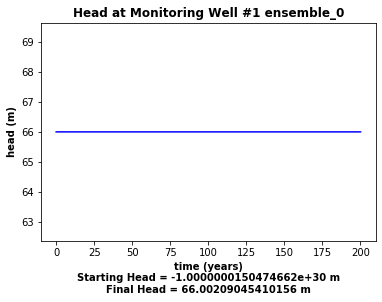

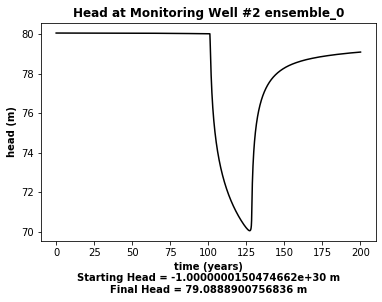

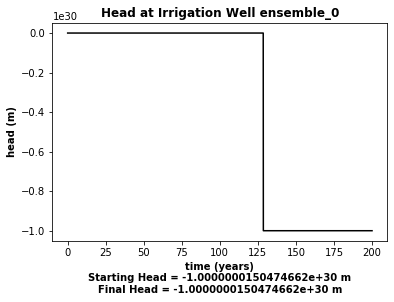

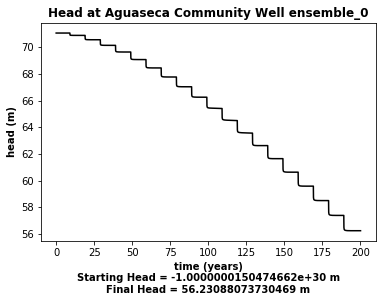

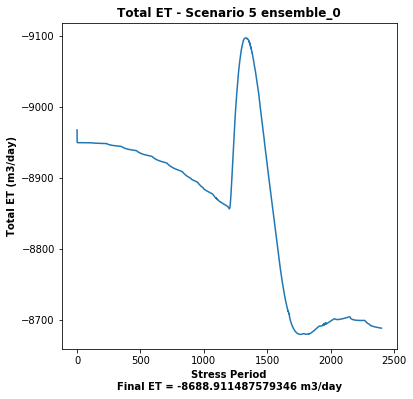

The final recharge sum for ensemble_0 is 9621.0
Total Daily flux from river to groundwater in the final year for ensemble_0 is 1200.0 m3/day


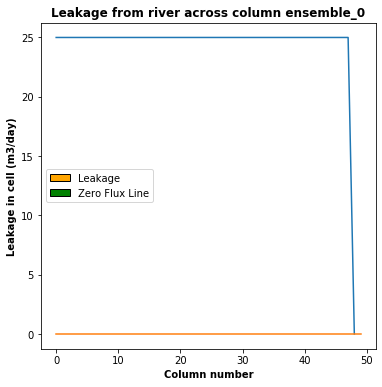

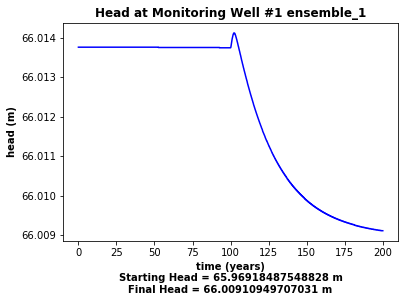

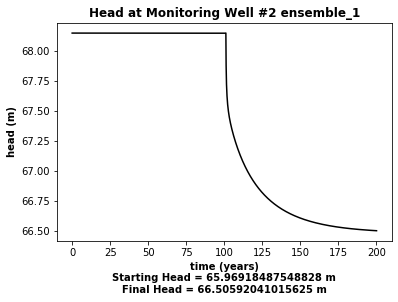

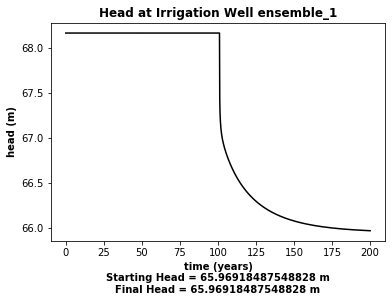

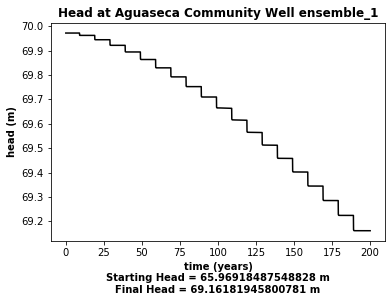

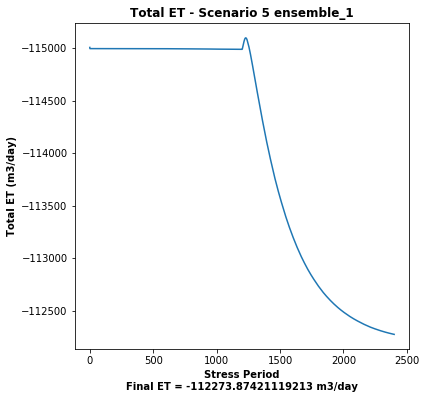

The final recharge sum for ensemble_1 is 9620.0
Total Daily flux from river to groundwater in the final year for ensemble_1 is 1200.0 m3/day


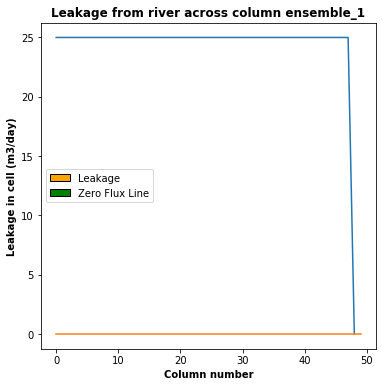

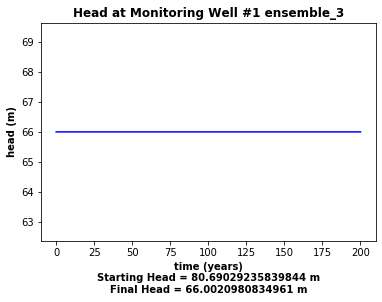

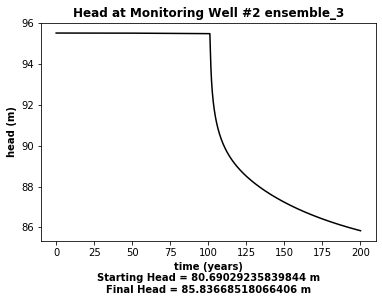

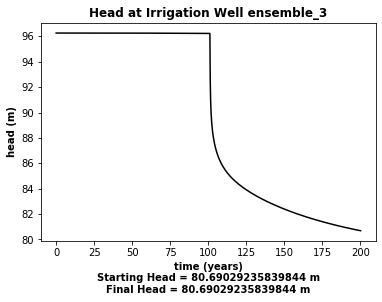

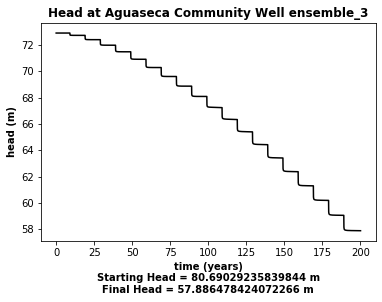

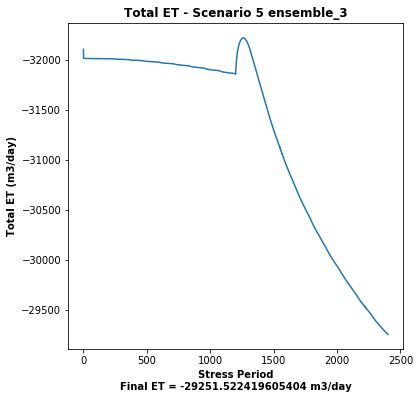

The final recharge sum for ensemble_3 is 35699.99751281738
Total Daily flux from river to groundwater in the final year for ensemble_3 is 1200.0 m3/day


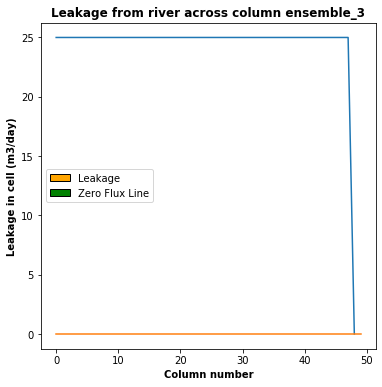

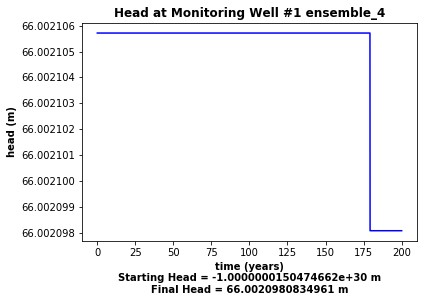

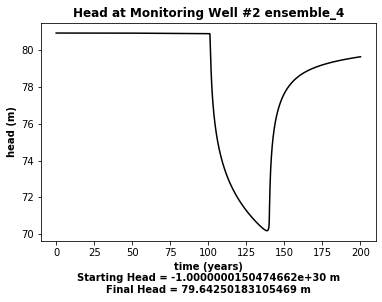

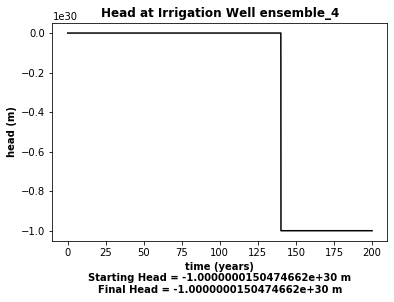

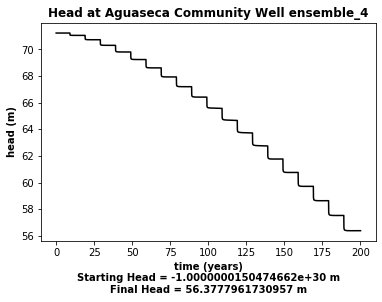

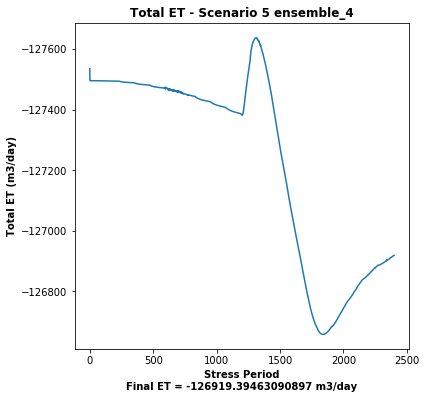

The final recharge sum for ensemble_4 is 9621.0
Total Daily flux from river to groundwater in the final year for ensemble_4 is 120000.0 m3/day


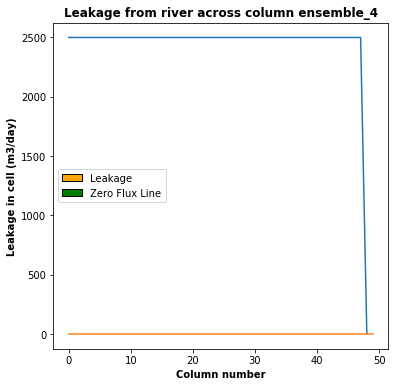

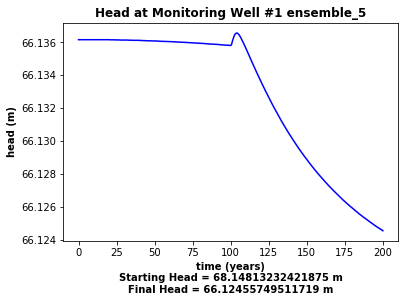

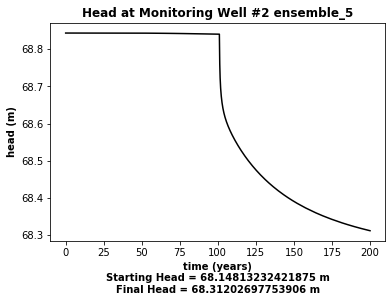

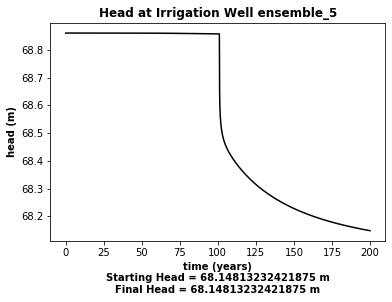

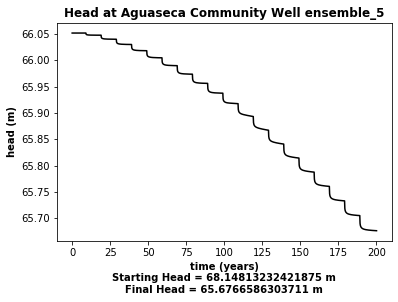

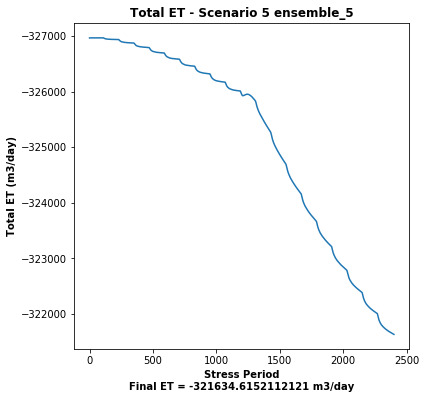

The final recharge sum for ensemble_5 is 35699.99751281738
Total Daily flux from river to groundwater in the final year for ensemble_5 is 1200.0 m3/day


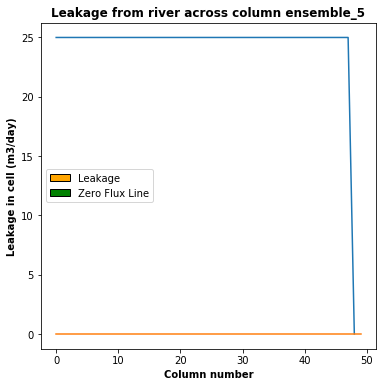

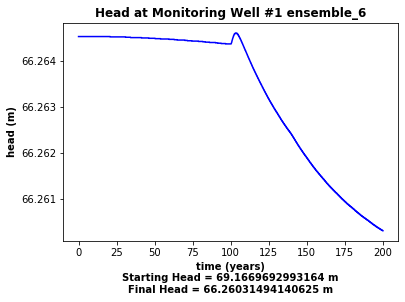

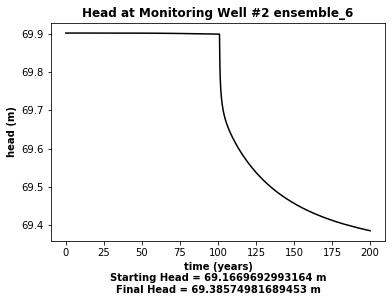

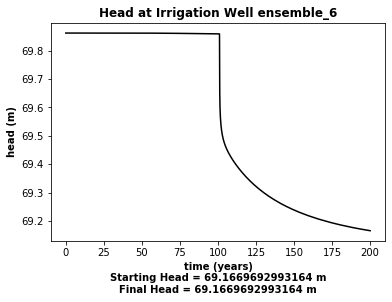

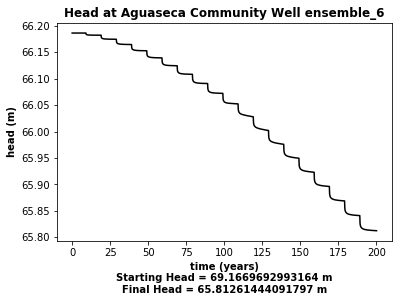

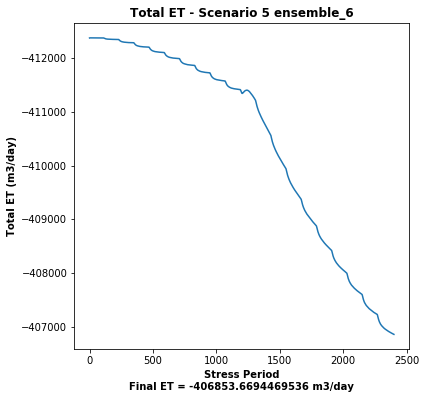

The final recharge sum for ensemble_6 is 9620.0
Total Daily flux from river to groundwater in the final year for ensemble_6 is 120000.0 m3/day


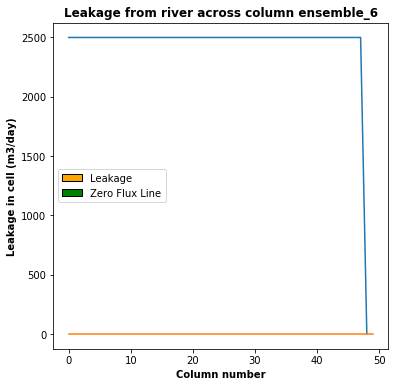

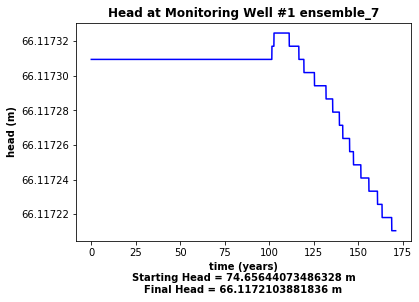

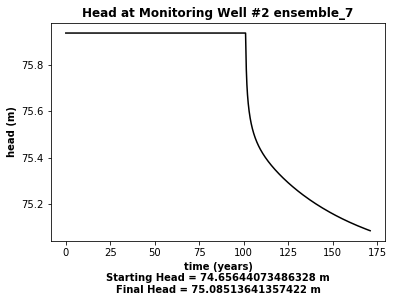

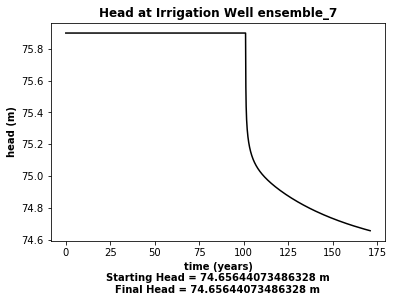

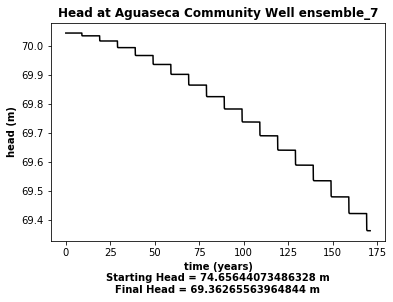

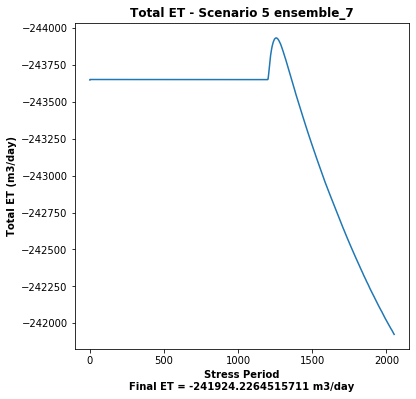

The final recharge sum for ensemble_7 is 35699.99751281738
Total Daily flux from river to groundwater in the final year for ensemble_7 is 120000.0 m3/day


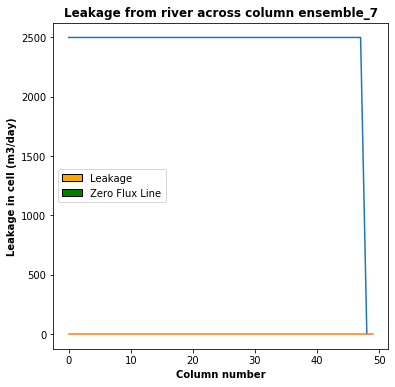

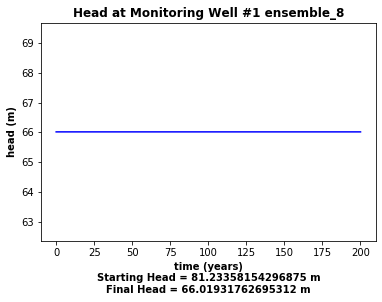

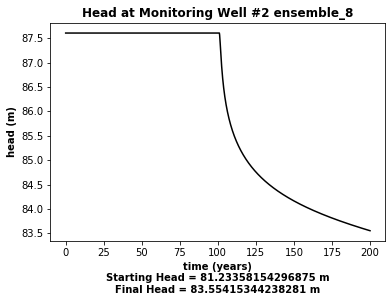

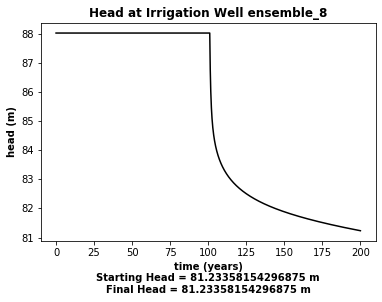

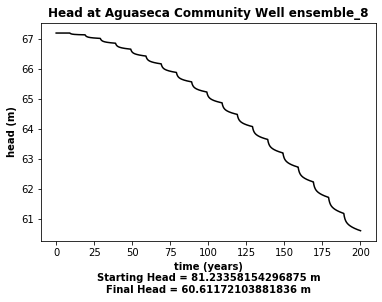

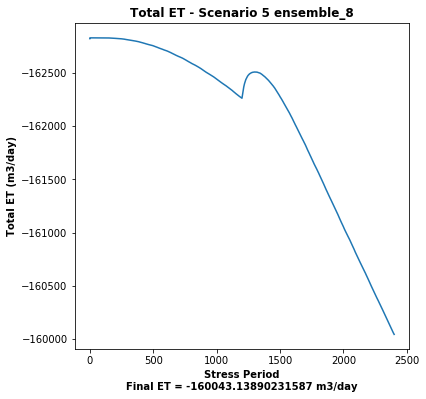

The final recharge sum for ensemble_8 is 35699.99751281738
Total Daily flux from river to groundwater in the final year for ensemble_8 is 120000.0 m3/day


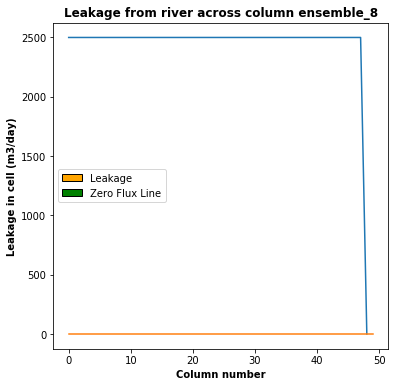

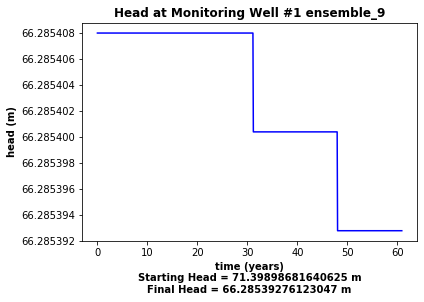

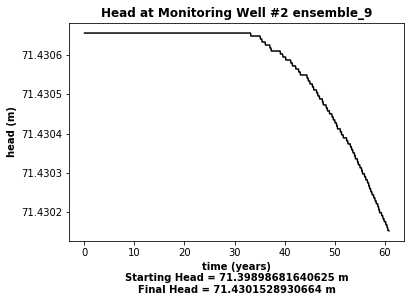

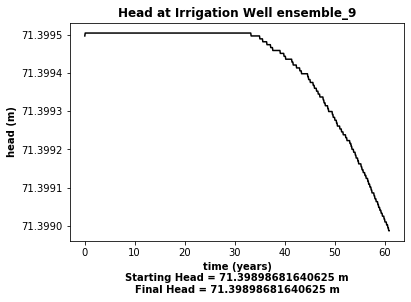

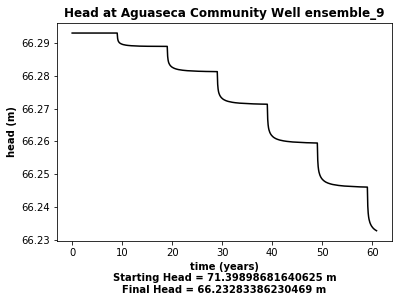

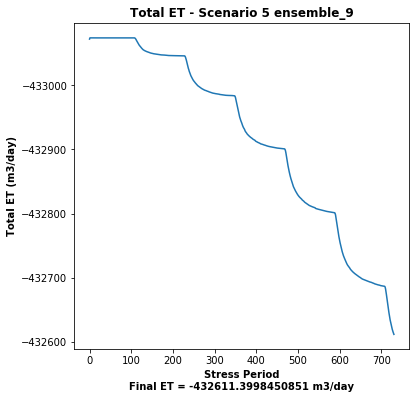

The final recharge sum for ensemble_9 is 35099.99751281738
Total Daily flux from river to groundwater in the final year for ensemble_9 is 120000.0 m3/day


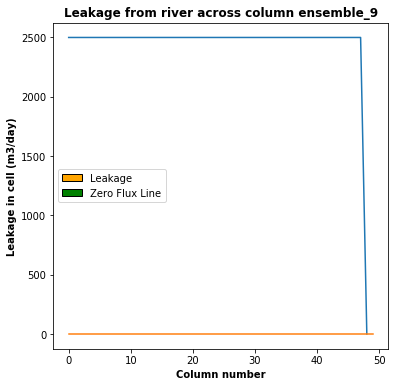

In [9]:
#Read loop start

for x in [0,1,3,4,5,6,7,8,9]:
    modelname = "ensemble_" + str(x)
    #Read in files from the run 
    
    hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
    times = hds.get_times()                               # returns a list of timesteps

    #extract binary data from head file
    head = {} #create dictionary to store head data 
    frf = {} #create dictionary to store flows through right cell face 
    fff = {} #create dictionary to store flows through front cell face 
    storage = {} #create dictionary to store storage
    ET = {}

    headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
    budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

    #get data from python objects
    for stress_per, time in enumerate(times): #iterate through times at end of each stress period
        head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
        frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) 
        fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
        storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        ET['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        
    #Plot head at monitoring wells 
    #get time series for a certain cell

    cell_id1 = (0,25,24) #cell ID of MW1
    cell_id2 = (0,37,12) #cell ID of MW2
    ag_id = (0,38,12)#cell ID of ag well
    agua_id = (2,29,37) #Cell ID of aguaseca community well

    time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
    time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
    time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
    time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
    
    
    #create plot of MW1
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Monitoring Well #1 " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][0, 25, 24]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record
    plt.savefig("Head_M1_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of MW2
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Monitoring Well #2 " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][0, 37, 12]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series2[:, 0]/360, time_series2[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_M2_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of Ag well
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Irrigation Well " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][0,38,12]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series_ag[:, 0]/360, time_series_ag[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_Ag_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of Aguaseca com well
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Aguaseca Community Well " + str(modelname),fontweight='bold')
    plt.xlabel('time (years)\n'f"Starting Head = {head['sp%s'%(0)][0,38,12]} m\n"
               f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series_agua[:, 0]/360, time_series_agua[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_Aqua_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()
    
    #ET things
    ET_data = budgobj.get_data(text='ET')
    #print(np.sum(ET_data[0]))
    ET_time_series = []
    x_val = []
    for i in (range(len(ET_data))):
        test_sum = np.sum(ET_data[i])
        if test_sum == 2500:
            print("skipped")
        else:
            ET_time_series.append(test_sum)
            x_val.append(i)
             #print("attached")
            
    fig = plt.figure(figsize=(6, 6))
    plt.plot(x_val, ET_time_series)
    plt.gca().invert_yaxis()
    plt.plot()
    plt.title('Total ET - Scenario 5 '+ str(modelname),fontweight='bold')
    plt.xlabel('Stress Period\n'f"Final ET = {ET_time_series[len(ET_time_series)-1]} m3/day",fontweight='bold')
    plt.ylabel("Total ET (m3/day)", fontweight = 'bold')
    plt.savefig("ET_time_series_"+str(modelname)+".png",dpi=600,bbox_inches='tight')                   
    plt.show()
    
    #Recharge things
    Recharge_data = budgobj.get_data(text='RECHARGE')
     #for i in (range(len(Recharge_data))):
         #print("The recharge sum at ",i,'for',str(modelname),'is',np.sum(Recharge_data[i])) 
    print("The final recharge sum for",str(modelname),'is',np.sum(Recharge_data[len(Recharge_data)-1]))    
    
    #Leakage things 
    leakage = budgobj.get_data(text='RIVER LEAKAGE')
    position = len(leakage)-1
    leak=leakage[position]
    tot_leak = sum(leak.q)
    
    print("Total Daily flux from river to groundwater in the final year for",str(modelname),"is", round(tot_leak,2), "m3/day")
    
    #leakage plot
    x2 = []
    for n in range(0,50):
        x2.append(n)
    y2 = np.zeros(50)
    fig = plt.figure(figsize=(6, 6))
    x = list(range(49))
    plt.plot(x, leak.q)
    plt.plot(x2, y2)
    plt.plot()
    plt.title('Leakage from river across column '+ str(modelname),fontweight='bold')
    plt.xlabel('Column number', fontweight = 'bold')
    plt.ylabel("Leakage in cell (m3/day)", fontweight = 'bold')
    plt.legend(handles=[mp.patches.Patch(color='orange',label='Leakage',ec='black'),
                        mp.patches.Patch(color='green',label='Zero Flux Line',ec='black')])
    plt.savefig("leakage_last_year_"+str(modelname)+".png",dpi=600,bbox_inches='tight')                    
    plt.show()

Head at Community well for ensemble_0 = 56.23088


NameError: name 'head1' is not defined

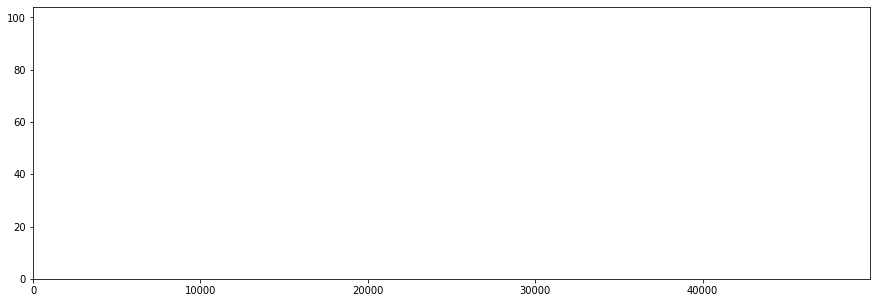

In [10]:

#loop start
for x in range(10):
    modelname = "ensemble_" + str(x)
    
    # Head - 1 layer model 
    headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
    times = headobj.get_times()                #returns a list of timesteps
    head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

    head_well = head[2,29,37]
    print("Head at Community well for", modelname , "=", head_well )

    # Crossection at Pumping Well row
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1)

    xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 29}) #note use the key 'column' if you want to plot a column instaed
    pc = xsect.plot_array(head1, masked_values=[999.], head=head, alpha=0.5)
    patches = xsect.plot_ibound(head=head1)
    #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
    #patches = xsect.plot_bc('WEL', color='red')
    linecollection = xsect.plot_grid(color='black', lw=0.5)
    t = ax.set_title('Row 29 Cross-Section for ' f'{modelname}')
    #plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')

    cb = plt.colorbar(pc, shrink=0.75)
    #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
    wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)


In [ ]:
#### 1 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head1)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('1 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)


In [ ]:

    #Read in files from the run 
    
    hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
    times = hds.get_times()                               # returns a list of timesteps

    #extract binary data from head file
    head = {} #create dictionary to store head data 
    frf = {} #create dictionary to store flows through right cell face 
    fff = {} #create dictionary to store flows through front cell face 
    #storage = {} #create dictionary to store storage
    #ET = {}

    headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
    budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

    #get data from python objects
    for stress_per, time in enumerate(times): #iterate through times at end of each stress period
        head['sp%s'%(stress_per)] = headobj.get_data() #append heads to head list for ea stress per
        frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) 
        fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
        #storage['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        #ET['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
        
    #Plot head at monitoring wells 
    #get time series for a certain cell

    cell_id1 = (0,25,24) #cell ID of MW1
    cell_id2 = (0,37,12) #cell ID of MW2
    ag_id = (0,38,12)#cell ID of ag well
    agua_id = (2,29,37) #Cell ID of aguaseca community well

    time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
    time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
    time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
    time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well
    
    
    #create plot of MW1
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Monitoring Well #1" + str(modelname),fontweight='bold')
    plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 25, 24]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
    plt.savefig("Head_M1_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of MW2
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Monitoring Well #2" + str(modelname),fontweight='bold')
    plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0, 37, 12]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_M2_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of Ag well
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Irrigation Well" + str(modelname),fontweight='bold')
    plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][0,38,12]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_Ag_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()

    #create plot of Aguaseca com well
    plt.subplot(1, 1, 1)
    ax=plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.title("Head at Aguaseca Community Well" + str(modelname),fontweight='bold'))
    plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')
    plt.ylabel('head (m)',fontweight='bold')
    plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
    plt.savefig("Head_Aqua_"+str(modelname)+".png",dpi=600,bbox_inches='tight')
    plt.show()
    
    #ET things
    ET_data = budgobj.get_data(text='ET')
    #print(np.sum(ET_data[0]))
    ET_time_series = []
    x_val = []
    for i in (range(len(ET_data))):
        test_sum = np.sum(ET_data[i])
        if test_sum == 2500:
            print("skipped")
        else:
            ET_time_series.append(test_sum)
            x_val.append(i)
            print("attached")
            
    fig = plt.figure(figsize=(6, 6))
    plt.plot(x_val, ET_time_series)
    plt.gca().invert_yaxis()
    plt.plot()
    plt.title('Total ET - Scenario 5',fontweight='bold')
    plt.xlabel('Stress Period\n'f"Final ET = {ET_time_series[len(ET_time_series)-1]} m3/day",fontweight='bold')
    plt.ylabel("Total ET (m3/day)", fontweight = 'bold')
    plt.savefig("ET_time_series_"+str(modelname)+".png",dpi=600,bbox_inches='tight')                   
    plt.show()
    
    #Recharge things
    Recharge_data = budgobj.get_data(text='RECHARGE')
    for i in (range(len(Recharge_data))):
        print("The recharge sum at ",i,'for',str(modelname),'is',np.sum(Recharge_data[i])) 
        
    #Leakage things 
    leakage = budgobj.get_data(text='RIVER LEAKAGE')
    position = len(leakage)-1
    leak=leakage[position]
    tot_leak = sum(leak.q)
    
    print("Total Daily flux from river to groundwater in the final year for",str(modelname),"is", round(tot_leak,2), "m3/day")
    
    #leakage plot
    x2 = []
    for n in range(0,50):
        x2.append(n)
    y2 = np.zeros(50)
    fig = plt.figure(figsize=(6, 6))
    x = list(range(49))
    plt.plot(x, leak.q)
    plt.plot(x2, y2)
    plt.plot()
    plt.title('Leakage from river across column',fontweight='bold')
    plt.xlabel('Column number', fontweight = 'bold')
    plt.ylabel("Leakage in cell (m3/day)", fontweight = 'bold')
    plt.legend(handles=[mp.patches.Patch(color='orange',label='Leakage',ec='black'),
                        mp.patches.Patch(color='green',label='Zero Flux Line',ec='black')])
    plt.savefig("leakage_last_year_"+str(modelname)+".png",dpi=600,bbox_inches='tight')                    
    plt.show()

### Leakage calculation

In [ ]:
well_loc
head['sp0'][0][19][38]
#head['sp0'][well_loc[0]][well_loc[1]][well_loc[2]]

#budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
#leakage = budgobj.get_data(text='RIVER LEAKAGE')
#print(leakage[0])
perflux = np.array(range(nper))

for i in range(nper-1):
    ##print("Stream Leakage for Stress period %s"%i)
    perflux[i] = 0
    for k in range(len(leakage['sp%s'%i][0])):
        #print(leakage['sp%s'%i][0][k][1])
        perflux[i] = perflux[i] + leakage['sp%s'%i][0][k][1]
        #flux[i] = flux[i] + leakage[0][k][1]
    
print(perflux)    


## Water Budget calculations

In [ ]:
print(len(head))
##STream Leakage

t2 = max(enumerate(times))
t = t2[0] - 12
print(t)
leak = 0
for i in range(12):
    leak = leak + np.sum(leakage['sp%s'%(t+i)][0].q)
print("Total stream leakge at year 100:")    
print(leak)   
# t = 0
# ileak = 0
# for i in range(12):
#     ileak = ileak + np.sum(leakage['sp%s'%(t+i)][0].q)
    
# print(int(ileak))    

##GW outflow
t = t2[0] - 12
print(t)
frf_total = 0
for k in range(nlay):
    for i in range(12):
        frf_total = frf_total + np.sum(frf['sp%s'%(t+i)][0][k][:][48])

print("Total GW outflow 100 year:")
print(frf_total)
#print(np.sum(leakage['sp0'][0].q) - np.sum(leakage['sp1199'][0].q))

## ET
t = t2[0] - 12
print(t)
ET_total = 0
for i in range(12):
       ET_total = ET_total + np.sum(np.sum(et['sp%s'%(t+i)][0][1][:][:]))
print("Total ET at year 100:")
print(ET_total) 

## Recharge
t = t2[0] - 12
print(t)
rech_total = 0
for i in range(12):
       rech_total = rech_total + np.sum(np.sum(recharge['sp%s'%(t+i)][0][1][:][:]))
print("Total rech at year 100:")
print(rech_total)     


### Testing stuff

In [ ]:
type(times)
len(times)


In [ ]:
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

### Storage

In [ ]:
# #testing things
# type(stor)
# stor.keys()
# #stor.values()

# type(stor["sp1"])
# print(stor["sp1"])

# SUM=(sum(stor["sp1"]))
# print(SUM)

# print(stor['sp1'][0][0].shape)

# startlay0 = (stor['sp0'][0][0])
# startlay1 = (stor['sp0'][0][1])
# startlay2 = (stor['sp0'][0][2])
# start_stor = startlay0 + startlay1 + startlay2
# print(start_stor.sum())

# endlay0 = (stor['sp1199'][0][0])
# endlay1 = (stor['sp1199'][0][1])
# endlay2 = (stor['sp1199'][0][2])
# end_stor = endlay0 + endlay1 + endlay2
# print(end_stor.sum())

#storage change
storage_change = 0
for i in range(sim_years*sp_peryr*nstp[0]):
    storage_i = stor['sp%s'%(i)][0][:].sum()
    storage_change = storage_change + storage_i
print(storage_change)

#yearly storage
yearly_stor = {}
storage_change = 0
yearlist = list(range(100))
for i in range(len(yearlist)):
    yearlist[i] = yearlist[i]*12
#print(yearlist)

for i in yearlist:
    storage_change = 0
    for sp in range(12):
        timestep = i + sp
        storage_i = stor['sp%s'%(timestep)][0][:].sum()
        storage_change = storage_change + storage_i
        #print(storage_change)
        if sp == 11:
            yearly_stor[i/12] = storage_change
            print('year', i/12, storage_change)
            
            
#more storage stuff
storage_tot = 0
for i in range(100):
    storage_tot = storage_tot + yearly_stor[i]
    
print(storage_tot)
print(0.000810714*storage_tot)


yearlist2 = list(range(100))
print(yearlist2)
print(type(yearly_stor))
stor_ls = []
for i in range(100):
    stor_ls.append(yearly_stor[i])
  

In [ ]:
plt.subplot(1, 1, 1)
plt.title("Change in Storage",fontweight='bold')
plt.xlabel('Year',fontweight='bold')
plt.ylabel('Change Storage',fontweight='bold')
plt.plot(yearlist2, stor_ls, 'b-', color="darkblue") #plot the time series with points at each record
# plt.savefig('storage.png', dpi=600)
plt.show()


#### Cumulative storage

In [ ]:
cum_storage_ls = []
cum_storage = 0
for i in range(100):
    cum_storage = cum_storage + yearly_stor[i]
    cum_storage_ls.append(cum_storage)
    

In [ ]:
plt.subplot(1, 1, 1)
plt.title("Cumulative Change in Storage",fontweight='bold')
plt.xlabel('Year',fontweight='bold')
plt.ylabel('Change Storage',fontweight='bold')
plt.plot(yearlist2, cum_storage_ls, 'b-', color="purple") #plot the time series with points at each record
# plt.savefig('cumstorage.png', dpi=600)
plt.show()

## Modpath

In [ ]:
moddirmp="/Applications/MODFLOW/mp7"
#moddirmp="/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mp7"

mpname=os.path.join(modelname + '_mp')

#Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
locsb = [[0, 28, 18, 0, 30, 20]]
#locsb = [[0, 0, 0, 0, 49, 49]]
#set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=2, rowcelldivisions=2, layercelldivisions=2)
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='total', 
                                  particlegroups= particlegroups)

mp.add_package(rch) # write modpath datasets

mp.write_input()

# run modpath
mp.run_model()

mp.get_package_list()

### Read in Modpath outputs

In [ ]:
#load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

#make a subset which is particles ending in the Aquaseca well
nodewell = m.dis.get_node([(2, well_row, well_col)])
print(nodewell)
pwell1 = p.get_destination_pathline_data(dest_cells=nodewell)
ewell1 = e.get_destination_endpoint_data(dest_cells=nodewell)

#make a subset which is particles ending in the irrigation well
nodewell4 = m.dis.get_node([(0, well4_row, well4_col)])
print(nodewell4)
pwell4 = p.get_destination_pathline_data(dest_cells=nodewell4)
ewell4 = e.get_destination_endpoint_data(dest_cells=nodewell4)

print(pall)

### Plotting particles

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('Flowlines')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell1, layer='all', color='red', lw=0.5, linestyle=':', label='Aquaseca well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell4, layer='all', color='green', lw=0.5, linestyle=':', label='Irrigation well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# # mm.ax.legend();
#plt.tight_layout();
# plt.savefig('Pathlines1.png', dpi=600)